<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#train-데이터-로드-및-모델-정의" data-toc-modified-id="train-데이터-로드-및-모델-정의-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>train 데이터 로드 및 모델 정의</a></span></li><li><span><a href="#Entity-위치-정보-수정-함수-정의" data-toc-modified-id="Entity-위치-정보-수정-함수-정의-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Entity 위치 정보 수정 함수 정의</a></span></li><li><span><a href="#Augmentation-함수-정의" data-toc-modified-id="Augmentation-함수-정의-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Augmentation 함수 정의</a></span></li><li><span><a href="#원본-Train-데이터-확인" data-toc-modified-id="원본-Train-데이터-확인-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>원본 Train 데이터 확인</a></span></li><li><span><a href="#증강-대상-Label-정의" data-toc-modified-id="증강-대상-Label-정의-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>증강 대상 Label 정의</a></span></li><li><span><a href="#증강-실행" data-toc-modified-id="증강-실행-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>증강 실행</a></span></li><li><span><a href="#증강-완료-및-데이터-확인" data-toc-modified-id="증강-완료-및-데이터-확인-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>증강 완료 및 데이터 확인</a></span></li><li><span><a href="#증강-데이터-확인" data-toc-modified-id="증강-데이터-확인-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>증강 데이터 확인</a></span></li><li><span><a href="#데이터-저장을-위한-id-재설정-및-shuffle" data-toc-modified-id="데이터-저장을-위한-id-재설정-및-shuffle-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>데이터 저장을 위한 id 재설정 및 shuffle</a></span></li><li><span><a href="#데이터-저장" data-toc-modified-id="데이터-저장-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>데이터 저장</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import transformers
from transformers import pipeline
import random
from tqdm.notebook import tqdm

from matplotlib import font_manager, rc
import platform

if platform.system() == 'Windows':
    rc('font', family = 'Malgun Gothic')
elif platform.system() == 'Darwin':
    rc('font', famaily = 'AppleGothic')
else:
    rc('font', family = 'NanumGothic')

# train 데이터 로드 및 모델 정의

In [6]:
train_df = pd.read_csv('./nlp2_train.csv')

In [7]:
model = transformers.RobertaForMaskedLM.from_pretrained("klue/roberta-large")
tokenizer = transformers.AutoTokenizer.from_pretrained("klue/roberta-large")
nlp_fill = pipeline('fill-mask', model=model, tokenizer=tokenizer, top_k = 5)

# Entity 위치 정보 수정 함수 정의

In [3]:
def fix_entity_index(
    sentence: str, subject_entity: str, object_entity: str
    ) -> tuple:
    """
    전처리가 완료된 문장 sentence와 원본 데이터의 subject_entity, object_entity를 입력으로 받습니다.
    전처리로 인해 위치가 바뀐 subject_word와 object_word의 start_index와 end_index를 수정하여 수정된 (subject_entity, object_entity)의 tuple을 리턴합니다.
    """
    # str의 entity를 dict로 변경합니다.
    dict_subject = eval(subject_entity)
    dict_object = eval(object_entity)
    
    # entity dict에 속한 값을 가져옵니다.
    s_word, s_start, s_end, s_typ = dict_subject.values()
    o_word, o_start, o_end, o_typ = dict_object.values()
    
    # 전처리된 문장 sentence에서 subject entity의 word를 찾아 matched에 저장합니다.
    # finditer를 사용하는 이유는 찾고자 하는 word가 sentence내에 여러개 있을 수 있기 때문입니다.
    matched = re.finditer(re.escape(s_word), sentence)
    new_standard = float("inf")

    # 매치된 문장 내 단어 정보를 순회합니다.
    for word in matched:
        # 전처리 이전 문장의 start_index(변수명: s_start)를 기준으로, 전처리된 문장 내 word 위치와의 차이를 계산하여 차이가 가장 작은 단어를 탐색합니다
        start_standard = abs(s_start - word.span()[0])
        if new_standard >= start_standard:
            s, e = word.span()[0], word.span()[1] - 1
            new_standard = start_standard
    dict_subject['start_idx'], dict_subject['end_idx']= s, e

    # 동일한 작업을 dict_object에도 수행합니다.
    matched = re.finditer(re.escape(o_word), sentence)
    new_standard = float("inf")

    for word in matched:
        start_standard = abs(o_start - word.span()[0])
        if new_standard >= start_standard:
            s, e = word.span()[0], word.span()[1] - 1
            new_standard = start_standard
    dict_object['start_idx'], dict_object['end_idx']= s, e
    
    dict_subject = str(dict_subject)
    dict_object = str(dict_object)
    
    return (dict_subject, dict_object)

# Augmentation 함수 정의

In [9]:
def random_pick(target_list, random_id):
    check = False
    for item in random_id:
        symbol_list = re.findall(r"[^,.가-힣0-9A-Za-z]", target_list[item])
        if symbol_list:
            check = True
            return check
    return check

def masking(random_id, target_list):
    masked_words = []
    masked_list = target_list.copy()
    for i in random_id:
        masked_words.append(target_list[i])
        masked_list[i] = '[MASK]'
    return masked_list, masked_words

def inference_mask(random_id, nominee, masked_words, masked_list):
    temp = masked_words.copy()
    result = masked_list.copy()
    if len(random_id) == 1:
        for dictionary in nominee:
            if dictionary['token_str'] != temp[0] and dictionary['token_str'] != '[UNK]' and dictionary['token_str'] != '[CLS]' and dictionary['token_str'] != '[SEP]' and dictionary['token_str'] != '[PAD]':
                result[random_id[0]] = dictionary['token_str']
                break
    else:
        for idx, word in enumerate(random_id):
            for dictionary in nominee[idx]:
                if dictionary['token_str'] != temp[idx] and dictionary['token_str'] != '[UNK]' and dictionary['token_str'] != '[CLS]' and dictionary['token_str'] != '[SEP]' and dictionary['token_str'] != '[PAD]':
                    result[word] = dictionary['token_str']
                    break
    return result

def remove_hashtag(sentence):
    sentence = sentence.replace(" ##", "")
    return sentence

def data_augmentation(input_df, model, tokenizer):
    nlp_fill = pipeline('fill-mask', model=model, tokenizer=tokenizer, top_k = 5)
    df = input_df.copy()
    result_df = pd.DataFrame({'id':[], 'sentence':[], 'subject_entity':[], 'object_entity':[], 'label':[], 'source':[]})
    for row in tqdm(df.iterrows(), total = len(df)):
        idx, sentence, subject_entity, object_entity, label, source = row[1].id, row[1].sentence, row[1].subject_entity, row[1].object_entity, row[1].label, row[1].source
        s_word, o_word = eval(subject_entity)['word'], eval(object_entity)['word']
        sentence = sentence.replace(s_word, '[ENTITY1]')
        sentence = sentence.replace(o_word, '[ENTITY2]')
        
        target_list = sentence.split(' ')
        length = len(target_list)
        target_length = 1 if int(length * 0.1) == 0 else int(length * 0.1)
        if length < 4:
            continue
        
        mask_index_container = set()
        for i in range(4):
            random_id = random.sample(range(length), target_length)
            entity_check = random_pick(target_list, random_id)
            while entity_check:
                random_id = random.sample(range(length), target_length)
                entity_check = random_pick(target_list, random_id)
            mask_index_container.add(tuple(random_id))
        
        print("complete mask_index_container row", idx)
        
        for id_pairs in mask_index_container:
            id_pairs = sorted(id_pairs)
            masked_list, masked_words = masking(id_pairs, target_list)
            masked_sentence = ' '.join(masked_list)
            nominee = nlp_fill(masked_sentence)
            inferenced_sentence_list = inference_mask(id_pairs, nominee, masked_words, masked_list)
            inferenced_sentence = ' '.join(inferenced_sentence_list)
            inferenced_sentence = remove_hashtag(inferenced_sentence)
            inferenced_sentence = inferenced_sentence.replace('[ENTITY1]', s_word)
            inferenced_sentence = inferenced_sentence.replace('[ENTITY2]', o_word)
            edited_subject_entity, edited_object_entity = fix_entity_index(inferenced_sentence, subject_entity, object_entity)
            result_df.loc[len(result_df)] = [idx, inferenced_sentence, edited_subject_entity, edited_object_entity, label, source]
        
        print("complete data augmentation row", idx)
            
    return result_df

# 원본 Train 데이터 확인

In [8]:
train_df

,id,sentence,subject_entity,object_entity,label,source
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation,wikipedia
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,"{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation,wikitree
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,"{'word': '광주FC', 'start_idx': 21, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 34, 'end_idx...",org:member_of,wikitree
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees,wikitree
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,"{'word': '요미우리 자이언츠', 'start_idx': 22, 'end_id...","{'word': '1967', 'start_idx': 0, 'end_idx': 3,...",no_relation,wikipedia
...,...,...,...,...,...,...
32465,32465,한국당은 7일 오전 9시부터 오후 5시까지 진행된 원내대표 및 정책위의장 후보자 등...,"{'word': '유기준', 'start_idx': 93, 'end_idx': 95...","{'word': '부산 서구·동구', 'start_idx': 100, 'end_id...",per:employee_of,wikitree
32466,32466,"법포는 다시 최시형, 서병학, 손병희 직계인 북접과 다시 서장옥, 전봉준, 김개남을...","{'word': '최시형', 'start_idx': 7, 'end_idx': 9, ...","{'word': '손병희', 'start_idx': 17, 'end_idx': 19...",per:colleagues,wikipedia
32467,32467,완도군(군수 신우철)이 국토교통부에서 실시한 '2019 교통문화지수 실태조사'에서 ...,"{'word': '완도군', 'start_idx': 0, 'end_idx': 2, ...","{'word': '신우철', 'start_idx': 7, 'end_idx': 9, ...",org:top_members/employees,wikitree
32468,32468,"중앙일보, JTBC 회장을 지낸 이후 중앙홀딩스 회장, 재단법인 한반도평화만들기 이...","{'word': 'JTBC', 'start_idx': 6, 'end_idx': 9,...","{'word': '중앙홀딩스', 'start_idx': 21, 'end_idx': ...",no_relation,wikipedia


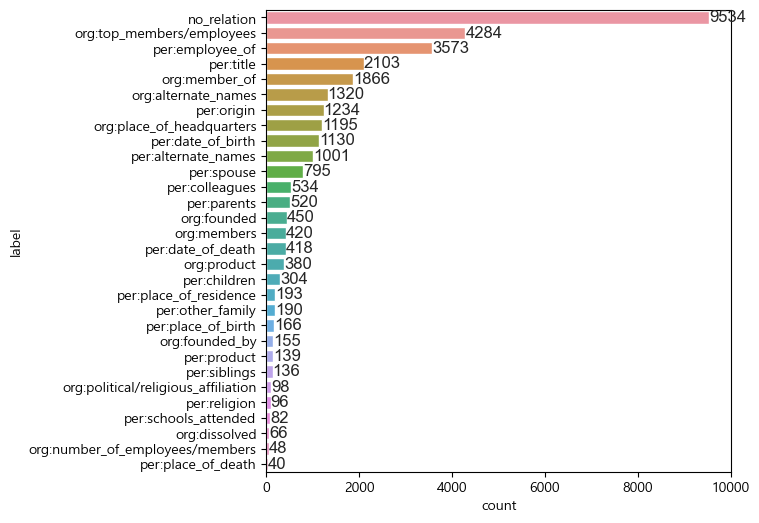

In [10]:
plt.subplots(figsize = (6,6))
sns.set(style='darkgrid')
ax = sns.countplot(y = train_df['label'], orient = 'h', order = train_df['label'].value_counts().index)
ax.bar_label(ax.containers[0])
#plt.tight_layout()
plt.show()

# 증강 대상 Label 정의

In [11]:
label_list = ['per:place_of_death', 'per:product', 'per:siblings', 'org:product', 
              'per:other_family', 'per:place_of_residence', 'per:place_of_death', 
              'per:religion', 'per:parents', 'org:dissolved', 'per:place_of_birth',
             "org:number_of_employees/members", 'org:founded', 'per:children', 
              'org:political/religious_affiliation', 'org:founded_by', 'per:spouse', 
              'per:colleagues', 'per:schools_attended', 'org:members']

# 증강 실행

In [12]:
df = train_df.copy()

for label_type in label_list:
    temp = train_df[train_df['label'] == label_type].copy()
    result = data_augmentation(temp, model, tokenizer)
    df = pd.concat([df, result])

  0%|          | 0/40 [00:00<?, ?it/s]

complete mask_index_container row 1044
complete data augmentation row 1044
complete mask_index_container row 1552
complete data augmentation row 1552
complete mask_index_container row 2214
complete data augmentation row 2214
complete mask_index_container row 2802
complete data augmentation row 2802
complete mask_index_container row 3510
complete data augmentation row 3510
complete mask_index_container row 4171
complete data augmentation row 4171
complete mask_index_container row 4421
complete data augmentation row 4421
complete mask_index_container row 4949
complete data augmentation row 4949
complete mask_index_container row 7229
complete data augmentation row 7229
complete mask_index_container row 7440
complete data augmentation row 7440
complete mask_index_container row 10522
complete data augmentation row 10522
complete mask_index_container row 11019
complete data augmentation row 11019
complete mask_index_container row 11309
complete data augmentation row 11309
complete mask_index

  0%|          | 0/139 [00:00<?, ?it/s]

complete mask_index_container row 703
complete data augmentation row 703
complete mask_index_container row 723
complete data augmentation row 723
complete mask_index_container row 793
complete data augmentation row 793
complete mask_index_container row 823
complete data augmentation row 823
complete mask_index_container row 903
complete data augmentation row 903
complete mask_index_container row 1204
complete data augmentation row 1204
complete mask_index_container row 1241
complete data augmentation row 1241
complete mask_index_container row 1576
complete data augmentation row 1576
complete mask_index_container row 2076
complete data augmentation row 2076
complete mask_index_container row 2240
complete data augmentation row 2240
complete mask_index_container row 3131
complete data augmentation row 3131
complete mask_index_container row 3504
complete data augmentation row 3504
complete mask_index_container row 3554
complete data augmentation row 3554
complete mask_index_container row 3

complete data augmentation row 24091
complete mask_index_container row 24356
complete data augmentation row 24356
complete mask_index_container row 24581
complete data augmentation row 24581
complete mask_index_container row 24784
complete data augmentation row 24784
complete mask_index_container row 25058
complete data augmentation row 25058
complete mask_index_container row 25151
complete data augmentation row 25151
complete mask_index_container row 25621
complete data augmentation row 25621
complete mask_index_container row 25624
complete data augmentation row 25624
complete mask_index_container row 25738
complete data augmentation row 25738
complete mask_index_container row 25797
complete data augmentation row 25797
complete mask_index_container row 25996
complete data augmentation row 25996
complete mask_index_container row 26574
complete data augmentation row 26574
complete mask_index_container row 26821
complete data augmentation row 26821
complete mask_index_container row 27210

  0%|          | 0/136 [00:00<?, ?it/s]

complete mask_index_container row 278
complete data augmentation row 278
complete mask_index_container row 958
complete data augmentation row 958
complete mask_index_container row 1017
complete data augmentation row 1017
complete mask_index_container row 1729
complete data augmentation row 1729
complete mask_index_container row 1825
complete data augmentation row 1825
complete mask_index_container row 3459
complete data augmentation row 3459
complete mask_index_container row 3462
complete data augmentation row 3462
complete mask_index_container row 3491
complete data augmentation row 3491
complete mask_index_container row 3683
complete data augmentation row 3683
complete mask_index_container row 3942
complete data augmentation row 3942
complete mask_index_container row 4165
complete data augmentation row 4165
complete mask_index_container row 4204
complete data augmentation row 4204
complete mask_index_container row 4473
complete data augmentation row 4473
complete mask_index_container

complete data augmentation row 25890
complete mask_index_container row 26112
complete data augmentation row 26112
complete mask_index_container row 26195
complete data augmentation row 26195
complete mask_index_container row 26733
complete data augmentation row 26733
complete mask_index_container row 27038
complete data augmentation row 27038
complete mask_index_container row 27055
complete data augmentation row 27055
complete mask_index_container row 27364
complete data augmentation row 27364
complete mask_index_container row 27820
complete data augmentation row 27820
complete mask_index_container row 28015
complete data augmentation row 28015
complete mask_index_container row 28092
complete data augmentation row 28092
complete mask_index_container row 28329
complete data augmentation row 28329
complete mask_index_container row 28676
complete data augmentation row 28676
complete mask_index_container row 28809
complete data augmentation row 28809
complete mask_index_container row 28967

  0%|          | 0/380 [00:00<?, ?it/s]

complete mask_index_container row 210
complete data augmentation row 210
complete mask_index_container row 257
complete data augmentation row 257
complete mask_index_container row 400
complete data augmentation row 400
complete mask_index_container row 453
complete data augmentation row 453
complete mask_index_container row 469
complete data augmentation row 469
complete mask_index_container row 620
complete data augmentation row 620
complete mask_index_container row 666
complete data augmentation row 666
complete mask_index_container row 765
complete data augmentation row 765
complete mask_index_container row 947
complete data augmentation row 947
complete mask_index_container row 952
complete data augmentation row 952
complete mask_index_container row 963
complete data augmentation row 963
complete mask_index_container row 965
complete data augmentation row 965
complete mask_index_container row 1068
complete data augmentation row 1068
complete mask_index_container row 1146
complete d

complete data augmentation row 9818
complete mask_index_container row 9850
complete data augmentation row 9850
complete mask_index_container row 9865
complete data augmentation row 9865
complete mask_index_container row 10170
complete data augmentation row 10170
complete mask_index_container row 10182
complete data augmentation row 10182
complete mask_index_container row 10339
complete data augmentation row 10339
complete mask_index_container row 10344
complete data augmentation row 10344
complete mask_index_container row 10374
complete data augmentation row 10374
complete mask_index_container row 10516
complete data augmentation row 10516
complete mask_index_container row 10557
complete data augmentation row 10557
complete mask_index_container row 10566
complete data augmentation row 10566
complete mask_index_container row 10820
complete data augmentation row 10820
complete mask_index_container row 11011
complete data augmentation row 11011
complete mask_index_container row 11042
comp

complete data augmentation row 18389
complete mask_index_container row 18411
complete data augmentation row 18411
complete mask_index_container row 18575
complete data augmentation row 18575
complete mask_index_container row 18606
complete data augmentation row 18606
complete mask_index_container row 18769
complete data augmentation row 18769
complete mask_index_container row 18795
complete data augmentation row 18795
complete mask_index_container row 19081
complete data augmentation row 19081
complete mask_index_container row 19177
complete data augmentation row 19177
complete mask_index_container row 19209
complete data augmentation row 19209
complete mask_index_container row 19211
complete data augmentation row 19211
complete mask_index_container row 19292
complete data augmentation row 19292
complete mask_index_container row 19341
complete data augmentation row 19341
complete mask_index_container row 19344
complete data augmentation row 19344
complete mask_index_container row 19390

complete data augmentation row 27649
complete mask_index_container row 27733
complete data augmentation row 27733
complete mask_index_container row 27932
complete data augmentation row 27932
complete mask_index_container row 27955
complete data augmentation row 27955
complete mask_index_container row 27986
complete data augmentation row 27986
complete mask_index_container row 28023
complete data augmentation row 28023
complete mask_index_container row 28145
complete data augmentation row 28145
complete mask_index_container row 28221
complete data augmentation row 28221
complete mask_index_container row 28282
complete data augmentation row 28282
complete mask_index_container row 28366
complete data augmentation row 28366
complete mask_index_container row 28390
complete data augmentation row 28390
complete mask_index_container row 28411
complete data augmentation row 28411
complete mask_index_container row 28665
complete data augmentation row 28665
complete mask_index_container row 28723

  0%|          | 0/190 [00:00<?, ?it/s]

complete mask_index_container row 199
complete data augmentation row 199
complete mask_index_container row 637
complete data augmentation row 637
complete mask_index_container row 683
complete data augmentation row 683
complete mask_index_container row 784
complete data augmentation row 784
complete mask_index_container row 872
complete data augmentation row 872
complete mask_index_container row 897
complete data augmentation row 897
complete mask_index_container row 962
complete data augmentation row 962
complete mask_index_container row 993
complete data augmentation row 993
complete mask_index_container row 1137
complete data augmentation row 1137
complete mask_index_container row 1738
complete data augmentation row 1738
complete mask_index_container row 1909
complete data augmentation row 1909
complete mask_index_container row 2182
complete data augmentation row 2182
complete mask_index_container row 2313
complete data augmentation row 2313
complete mask_index_container row 2344
co

complete data augmentation row 17668
complete mask_index_container row 17809
complete data augmentation row 17809
complete mask_index_container row 17914
complete data augmentation row 17914
complete mask_index_container row 17964
complete data augmentation row 17964
complete mask_index_container row 18208
complete data augmentation row 18208
complete mask_index_container row 18251
complete data augmentation row 18251
complete mask_index_container row 18252
complete data augmentation row 18252
complete mask_index_container row 18392
complete data augmentation row 18392
complete mask_index_container row 18395
complete data augmentation row 18395
complete mask_index_container row 18548
complete data augmentation row 18548
complete mask_index_container row 18560
complete data augmentation row 18560
complete mask_index_container row 18754
complete data augmentation row 18754
complete mask_index_container row 18939
complete data augmentation row 18939
complete mask_index_container row 19251

  0%|          | 0/193 [00:00<?, ?it/s]

complete mask_index_container row 167
complete data augmentation row 167
complete mask_index_container row 230
complete data augmentation row 230
complete mask_index_container row 233
complete data augmentation row 233
complete mask_index_container row 315
complete data augmentation row 315
complete mask_index_container row 503
complete data augmentation row 503
complete mask_index_container row 648
complete data augmentation row 648
complete mask_index_container row 766
complete data augmentation row 766
complete mask_index_container row 1066
complete data augmentation row 1066
complete mask_index_container row 1081
complete data augmentation row 1081
complete mask_index_container row 1265
complete data augmentation row 1265
complete mask_index_container row 1662
complete data augmentation row 1662
complete mask_index_container row 1969
complete data augmentation row 1969
complete mask_index_container row 2494
complete data augmentation row 2494
complete mask_index_container row 2590


complete data augmentation row 19638
complete mask_index_container row 19824
complete data augmentation row 19824
complete mask_index_container row 19933
complete data augmentation row 19933
complete mask_index_container row 19952
complete data augmentation row 19952
complete mask_index_container row 20013
complete data augmentation row 20013
complete mask_index_container row 20248
complete data augmentation row 20248
complete mask_index_container row 20813
complete data augmentation row 20813
complete mask_index_container row 20971
complete data augmentation row 20971
complete mask_index_container row 21342
complete data augmentation row 21342
complete mask_index_container row 21346
complete data augmentation row 21346
complete mask_index_container row 21364
complete data augmentation row 21364
complete mask_index_container row 21544
complete data augmentation row 21544
complete mask_index_container row 21669
complete data augmentation row 21669
complete mask_index_container row 21690

  0%|          | 0/40 [00:00<?, ?it/s]

complete mask_index_container row 1044
complete data augmentation row 1044
complete mask_index_container row 1552
complete data augmentation row 1552
complete mask_index_container row 2214
complete data augmentation row 2214
complete mask_index_container row 2802
complete data augmentation row 2802
complete mask_index_container row 3510
complete data augmentation row 3510
complete mask_index_container row 4171
complete data augmentation row 4171
complete mask_index_container row 4421
complete data augmentation row 4421
complete mask_index_container row 4949
complete data augmentation row 4949
complete mask_index_container row 7229
complete data augmentation row 7229
complete mask_index_container row 7440
complete data augmentation row 7440
complete mask_index_container row 10522
complete data augmentation row 10522
complete mask_index_container row 11019
complete data augmentation row 11019
complete mask_index_container row 11309
complete data augmentation row 11309
complete mask_index

  0%|          | 0/96 [00:00<?, ?it/s]

complete mask_index_container row 150
complete data augmentation row 150
complete mask_index_container row 244
complete data augmentation row 244
complete mask_index_container row 279
complete data augmentation row 279
complete mask_index_container row 590
complete data augmentation row 590
complete mask_index_container row 918
complete data augmentation row 918
complete mask_index_container row 1148
complete data augmentation row 1148
complete mask_index_container row 1249
complete data augmentation row 1249
complete mask_index_container row 1496
complete data augmentation row 1496
complete mask_index_container row 1733
complete data augmentation row 1733
complete mask_index_container row 1865
complete data augmentation row 1865
complete mask_index_container row 2090
complete data augmentation row 2090
complete mask_index_container row 2398
complete data augmentation row 2398
complete mask_index_container row 2524
complete data augmentation row 2524
complete mask_index_container row 2

  0%|          | 0/520 [00:00<?, ?it/s]

complete mask_index_container row 146
complete data augmentation row 146
complete mask_index_container row 219
complete data augmentation row 219
complete mask_index_container row 229
complete data augmentation row 229
complete mask_index_container row 476
complete data augmentation row 476
complete mask_index_container row 529
complete data augmentation row 529
complete mask_index_container row 580
complete data augmentation row 580
complete mask_index_container row 813
complete data augmentation row 813
complete mask_index_container row 866
complete data augmentation row 866
complete mask_index_container row 946
complete data augmentation row 946
complete mask_index_container row 998
complete data augmentation row 998
complete mask_index_container row 1074
complete data augmentation row 1074
complete mask_index_container row 1115
complete data augmentation row 1115
complete mask_index_container row 1156
complete data augmentation row 1156
complete mask_index_container row 1191
comple

complete data augmentation row 7374
complete mask_index_container row 7385
complete data augmentation row 7385
complete mask_index_container row 7435
complete data augmentation row 7435
complete mask_index_container row 7494
complete data augmentation row 7494
complete mask_index_container row 7600
complete data augmentation row 7600
complete mask_index_container row 7655
complete data augmentation row 7655
complete mask_index_container row 7691
complete data augmentation row 7691
complete mask_index_container row 7744
complete data augmentation row 7744
complete mask_index_container row 7803
complete data augmentation row 7803
complete mask_index_container row 7871
complete data augmentation row 7871
complete mask_index_container row 7916
complete data augmentation row 7916
complete mask_index_container row 8053
complete data augmentation row 8053
complete mask_index_container row 8085
complete data augmentation row 8085
complete mask_index_container row 8138
complete data augmentatio

complete data augmentation row 13783
complete mask_index_container row 13950
complete data augmentation row 13950
complete mask_index_container row 14020
complete data augmentation row 14020
complete mask_index_container row 14063
complete data augmentation row 14063
complete mask_index_container row 14160
complete data augmentation row 14160
complete mask_index_container row 14162
complete data augmentation row 14162
complete mask_index_container row 14592
complete data augmentation row 14592
complete mask_index_container row 14606
complete data augmentation row 14606
complete mask_index_container row 14616
complete data augmentation row 14616
complete mask_index_container row 14671
complete data augmentation row 14671
complete mask_index_container row 14726
complete data augmentation row 14726
complete mask_index_container row 14733
complete data augmentation row 14733
complete mask_index_container row 14850
complete data augmentation row 14850
complete mask_index_container row 14861

complete data augmentation row 20684
complete mask_index_container row 20698
complete data augmentation row 20698
complete mask_index_container row 20864
complete data augmentation row 20864
complete mask_index_container row 20998
complete data augmentation row 20998
complete mask_index_container row 21013
complete data augmentation row 21013
complete mask_index_container row 21024
complete data augmentation row 21024
complete mask_index_container row 21086
complete data augmentation row 21086
complete mask_index_container row 21105
complete data augmentation row 21105
complete mask_index_container row 21116
complete data augmentation row 21116
complete mask_index_container row 21117
complete data augmentation row 21117
complete mask_index_container row 21244
complete data augmentation row 21244
complete mask_index_container row 21298
complete data augmentation row 21298
complete mask_index_container row 21405
complete data augmentation row 21405
complete mask_index_container row 21413

complete data augmentation row 26535
complete mask_index_container row 26782
complete data augmentation row 26782
complete mask_index_container row 26888
complete data augmentation row 26888
complete mask_index_container row 26940
complete data augmentation row 26940
complete mask_index_container row 27144
complete data augmentation row 27144
complete mask_index_container row 27281
complete data augmentation row 27281
complete mask_index_container row 27336
complete data augmentation row 27336
complete mask_index_container row 27360
complete data augmentation row 27360
complete mask_index_container row 27388
complete data augmentation row 27388
complete mask_index_container row 27487
complete data augmentation row 27487
complete mask_index_container row 27714
complete data augmentation row 27714
complete mask_index_container row 27806
complete data augmentation row 27806
complete mask_index_container row 27811
complete data augmentation row 27811
complete mask_index_container row 27828

  0%|          | 0/66 [00:00<?, ?it/s]

complete mask_index_container row 102
complete data augmentation row 102
complete mask_index_container row 266
complete data augmentation row 266
complete mask_index_container row 1171
complete data augmentation row 1171
complete mask_index_container row 1471
complete data augmentation row 1471
complete mask_index_container row 1593
complete data augmentation row 1593
complete mask_index_container row 1752
complete data augmentation row 1752
complete mask_index_container row 1867
complete data augmentation row 1867
complete mask_index_container row 2122
complete data augmentation row 2122
complete mask_index_container row 2293
complete data augmentation row 2293
complete mask_index_container row 2303
complete data augmentation row 2303
complete mask_index_container row 2445
complete data augmentation row 2445
complete mask_index_container row 2647
complete data augmentation row 2647
complete mask_index_container row 3099
complete data augmentation row 3099
complete mask_index_container

  0%|          | 0/166 [00:00<?, ?it/s]

complete mask_index_container row 91
complete data augmentation row 91
complete mask_index_container row 774
complete data augmentation row 774
complete mask_index_container row 1105
complete data augmentation row 1105
complete mask_index_container row 1110
complete data augmentation row 1110
complete mask_index_container row 1300
complete data augmentation row 1300
complete mask_index_container row 1302
complete data augmentation row 1302
complete mask_index_container row 1393
complete data augmentation row 1393
complete mask_index_container row 1467
complete data augmentation row 1467
complete mask_index_container row 1633
complete data augmentation row 1633
complete mask_index_container row 1853
complete data augmentation row 1853
complete mask_index_container row 1920
complete data augmentation row 1920
complete mask_index_container row 2183
complete data augmentation row 2183
complete mask_index_container row 2520
complete data augmentation row 2520
complete mask_index_container r

complete data augmentation row 21646
complete mask_index_container row 21722
complete data augmentation row 21722
complete mask_index_container row 21759
complete data augmentation row 21759
complete mask_index_container row 22509
complete data augmentation row 22509
complete mask_index_container row 22680
complete data augmentation row 22680
complete mask_index_container row 23462
complete data augmentation row 23462
complete mask_index_container row 23818
complete data augmentation row 23818
complete mask_index_container row 23866
complete data augmentation row 23866
complete mask_index_container row 23885
complete data augmentation row 23885
complete mask_index_container row 24000
complete data augmentation row 24000
complete mask_index_container row 24090
complete data augmentation row 24090
complete mask_index_container row 24106
complete data augmentation row 24106
complete mask_index_container row 24274
complete data augmentation row 24274
complete mask_index_container row 24487

  0%|          | 0/48 [00:00<?, ?it/s]

complete mask_index_container row 72
complete data augmentation row 72
complete mask_index_container row 205
complete data augmentation row 205
complete mask_index_container row 954
complete data augmentation row 954
complete mask_index_container row 1026
complete data augmentation row 1026
complete mask_index_container row 1420
complete data augmentation row 1420
complete mask_index_container row 1547
complete data augmentation row 1547
complete mask_index_container row 2552
complete data augmentation row 2552
complete mask_index_container row 3752
complete data augmentation row 3752
complete mask_index_container row 4632
complete data augmentation row 4632
complete mask_index_container row 5351
complete data augmentation row 5351
complete mask_index_container row 5938
complete data augmentation row 5938
complete mask_index_container row 9261
complete data augmentation row 9261
complete mask_index_container row 10661
complete data augmentation row 10661
complete mask_index_container r

  0%|          | 0/450 [00:00<?, ?it/s]

complete mask_index_container row 67
complete data augmentation row 67
complete mask_index_container row 80
complete data augmentation row 80
complete mask_index_container row 88
complete data augmentation row 88
complete mask_index_container row 104
complete data augmentation row 104
complete mask_index_container row 123
complete data augmentation row 123
complete mask_index_container row 149
complete data augmentation row 149
complete mask_index_container row 156
complete data augmentation row 156
complete mask_index_container row 253
complete data augmentation row 253
complete mask_index_container row 341
complete data augmentation row 341
complete mask_index_container row 478
complete data augmentation row 478
complete mask_index_container row 511
complete data augmentation row 511
complete mask_index_container row 515
complete data augmentation row 515
complete mask_index_container row 559
complete data augmentation row 559
complete mask_index_container row 606
complete data augme

complete data augmentation row 7558
complete mask_index_container row 7597
complete data augmentation row 7597
complete mask_index_container row 7644
complete data augmentation row 7644
complete mask_index_container row 7696
complete data augmentation row 7696
complete mask_index_container row 7834
complete data augmentation row 7834
complete mask_index_container row 7847
complete data augmentation row 7847
complete mask_index_container row 7912
complete data augmentation row 7912
complete mask_index_container row 7997
complete data augmentation row 7997
complete mask_index_container row 8075
complete data augmentation row 8075
complete mask_index_container row 8080
complete data augmentation row 8080
complete mask_index_container row 8208
complete data augmentation row 8208
complete mask_index_container row 8633
complete data augmentation row 8633
complete mask_index_container row 8650
complete data augmentation row 8650
complete mask_index_container row 8726
complete data augmentatio

complete data augmentation row 15828
complete mask_index_container row 15852
complete data augmentation row 15852
complete mask_index_container row 15855
complete data augmentation row 15855
complete mask_index_container row 15957
complete data augmentation row 15957
complete mask_index_container row 15999
complete data augmentation row 15999
complete mask_index_container row 16047
complete data augmentation row 16047
complete mask_index_container row 16272
complete data augmentation row 16272
complete mask_index_container row 16342
complete data augmentation row 16342
complete mask_index_container row 16358
complete data augmentation row 16358
complete mask_index_container row 16431
complete data augmentation row 16431
complete mask_index_container row 16468
complete data augmentation row 16468
complete mask_index_container row 16521
complete data augmentation row 16521
complete mask_index_container row 16569
complete data augmentation row 16569
complete mask_index_container row 16674

complete data augmentation row 23476
complete mask_index_container row 23535
complete data augmentation row 23535
complete mask_index_container row 23777
complete data augmentation row 23777
complete mask_index_container row 23803
complete data augmentation row 23803
complete mask_index_container row 23953
complete data augmentation row 23953
complete mask_index_container row 23967
complete data augmentation row 23967
complete mask_index_container row 23972
complete data augmentation row 23972
complete mask_index_container row 24066
complete data augmentation row 24066
complete mask_index_container row 24188
complete data augmentation row 24188
complete mask_index_container row 24220
complete data augmentation row 24220
complete mask_index_container row 24485
complete data augmentation row 24485
complete mask_index_container row 24686
complete data augmentation row 24686
complete mask_index_container row 24693
complete data augmentation row 24693
complete mask_index_container row 24801

complete data augmentation row 31144
complete mask_index_container row 31250
complete data augmentation row 31250
complete mask_index_container row 31285
complete data augmentation row 31285
complete mask_index_container row 31343
complete data augmentation row 31343
complete mask_index_container row 31353
complete data augmentation row 31353
complete mask_index_container row 31476
complete data augmentation row 31476
complete mask_index_container row 31530
complete data augmentation row 31530
complete mask_index_container row 31706
complete data augmentation row 31706
complete mask_index_container row 31856
complete data augmentation row 31856
complete mask_index_container row 31874
complete data augmentation row 31874
complete mask_index_container row 31939
complete data augmentation row 31939
complete mask_index_container row 31980
complete data augmentation row 31980
complete mask_index_container row 32055
complete data augmentation row 32055
complete mask_index_container row 32086

  0%|          | 0/304 [00:00<?, ?it/s]

complete mask_index_container row 56
complete data augmentation row 56
complete mask_index_container row 353
complete data augmentation row 353
complete mask_index_container row 373
complete data augmentation row 373
complete mask_index_container row 396
complete data augmentation row 396
complete mask_index_container row 407
complete data augmentation row 407
complete mask_index_container row 423
complete data augmentation row 423
complete mask_index_container row 465
complete data augmentation row 465
complete mask_index_container row 468
complete data augmentation row 468
complete mask_index_container row 558
complete data augmentation row 558
complete mask_index_container row 602
complete data augmentation row 602
complete mask_index_container row 624
complete data augmentation row 624
complete mask_index_container row 768
complete data augmentation row 768
complete mask_index_container row 843
complete data augmentation row 843
complete mask_index_container row 991
complete data a

complete data augmentation row 12697
complete mask_index_container row 12822
complete data augmentation row 12822
complete mask_index_container row 12869
complete data augmentation row 12869
complete mask_index_container row 12883
complete data augmentation row 12883
complete mask_index_container row 12955
complete data augmentation row 12955
complete mask_index_container row 13130
complete data augmentation row 13130
complete mask_index_container row 13309
complete data augmentation row 13309
complete mask_index_container row 13437
complete data augmentation row 13437
complete mask_index_container row 13471
complete data augmentation row 13471
complete mask_index_container row 13493
complete data augmentation row 13493
complete mask_index_container row 13706
complete data augmentation row 13706
complete mask_index_container row 13918
complete data augmentation row 13918
complete mask_index_container row 13944
complete data augmentation row 13944
complete mask_index_container row 13990

complete data augmentation row 22294
complete mask_index_container row 22347
complete data augmentation row 22347
complete mask_index_container row 22372
complete data augmentation row 22372
complete mask_index_container row 22379
complete data augmentation row 22379
complete mask_index_container row 22581
complete data augmentation row 22581
complete mask_index_container row 22681
complete data augmentation row 22681
complete mask_index_container row 22744
complete data augmentation row 22744
complete mask_index_container row 22768
complete data augmentation row 22768
complete mask_index_container row 22904
complete data augmentation row 22904
complete mask_index_container row 23011
complete data augmentation row 23011
complete mask_index_container row 23133
complete data augmentation row 23133
complete mask_index_container row 23179
complete data augmentation row 23179
complete mask_index_container row 23195
complete data augmentation row 23195
complete mask_index_container row 23221

  0%|          | 0/98 [00:00<?, ?it/s]

complete mask_index_container row 50
complete data augmentation row 50
complete mask_index_container row 280
complete data augmentation row 280
complete mask_index_container row 355
complete data augmentation row 355
complete mask_index_container row 442
complete data augmentation row 442
complete mask_index_container row 516
complete data augmentation row 516
complete mask_index_container row 1144
complete data augmentation row 1144
complete mask_index_container row 1394
complete data augmentation row 1394
complete mask_index_container row 2172
complete data augmentation row 2172
complete mask_index_container row 2266
complete data augmentation row 2266
complete mask_index_container row 2678
complete data augmentation row 2678
complete mask_index_container row 2752
complete data augmentation row 2752
complete mask_index_container row 2848
complete data augmentation row 2848
complete mask_index_container row 3020
complete data augmentation row 3020
complete mask_index_container row 327

  0%|          | 0/155 [00:00<?, ?it/s]

complete mask_index_container row 35
complete data augmentation row 35
complete mask_index_container row 234
complete data augmentation row 234
complete mask_index_container row 459
complete data augmentation row 459
complete mask_index_container row 616
complete data augmentation row 616
complete mask_index_container row 679
complete data augmentation row 679
complete mask_index_container row 865
complete data augmentation row 865
complete mask_index_container row 1439
complete data augmentation row 1439
complete mask_index_container row 1555
complete data augmentation row 1555
complete mask_index_container row 1596
complete data augmentation row 1596
complete mask_index_container row 1598
complete data augmentation row 1598
complete mask_index_container row 1848
complete data augmentation row 1848
complete mask_index_container row 2585
complete data augmentation row 2585
complete mask_index_container row 2598
complete data augmentation row 2598
complete mask_index_container row 2754


complete data augmentation row 20555
complete mask_index_container row 20576
complete data augmentation row 20576
complete mask_index_container row 20601
complete data augmentation row 20601
complete mask_index_container row 20947
complete data augmentation row 20947
complete mask_index_container row 21058
complete data augmentation row 21058
complete mask_index_container row 21482
complete data augmentation row 21482
complete mask_index_container row 22072
complete data augmentation row 22072
complete mask_index_container row 22160
complete data augmentation row 22160
complete mask_index_container row 22198
complete data augmentation row 22198
complete mask_index_container row 22219
complete data augmentation row 22219
complete mask_index_container row 22265
complete data augmentation row 22265
complete mask_index_container row 22569
complete data augmentation row 22569
complete mask_index_container row 22969
complete data augmentation row 22969
complete mask_index_container row 23019

  0%|          | 0/795 [00:00<?, ?it/s]

complete mask_index_container row 22
complete data augmentation row 22
complete mask_index_container row 25
complete data augmentation row 25
complete mask_index_container row 33
complete data augmentation row 33
complete mask_index_container row 40
complete data augmentation row 40
complete mask_index_container row 77
complete data augmentation row 77
complete mask_index_container row 78
complete data augmentation row 78
complete mask_index_container row 86
complete data augmentation row 86
complete mask_index_container row 116
complete data augmentation row 116
complete mask_index_container row 121
complete data augmentation row 121
complete mask_index_container row 228
complete data augmentation row 228
complete mask_index_container row 239
complete data augmentation row 239
complete mask_index_container row 245
complete data augmentation row 245
complete mask_index_container row 246
complete data augmentation row 246
complete mask_index_container row 247
complete data augmentation 

complete data augmentation row 3682
complete mask_index_container row 3696
complete data augmentation row 3696
complete mask_index_container row 3723
complete data augmentation row 3723
complete mask_index_container row 3729
complete data augmentation row 3729
complete mask_index_container row 3759
complete data augmentation row 3759
complete mask_index_container row 3873
complete data augmentation row 3873
complete mask_index_container row 4100
complete data augmentation row 4100
complete mask_index_container row 4181
complete data augmentation row 4181
complete mask_index_container row 4213
complete data augmentation row 4213
complete mask_index_container row 4294
complete data augmentation row 4294
complete mask_index_container row 4295
complete data augmentation row 4295
complete mask_index_container row 4314
complete data augmentation row 4314
complete mask_index_container row 4399
complete data augmentation row 4399
complete mask_index_container row 4409
complete data augmentatio

complete data augmentation row 8273
complete mask_index_container row 8329
complete data augmentation row 8329
complete mask_index_container row 8365
complete data augmentation row 8365
complete mask_index_container row 8396
complete data augmentation row 8396
complete mask_index_container row 8424
complete data augmentation row 8424
complete mask_index_container row 8580
complete data augmentation row 8580
complete mask_index_container row 8619
complete data augmentation row 8619
complete mask_index_container row 8622
complete data augmentation row 8622
complete mask_index_container row 8643
complete data augmentation row 8643
complete mask_index_container row 8681
complete data augmentation row 8681
complete mask_index_container row 8682
complete data augmentation row 8682
complete mask_index_container row 8706
complete data augmentation row 8706
complete mask_index_container row 8719
complete data augmentation row 8719
complete mask_index_container row 8770
complete data augmentatio

complete data augmentation row 13024
complete mask_index_container row 13031
complete data augmentation row 13031
complete mask_index_container row 13050
complete data augmentation row 13050
complete mask_index_container row 13068
complete data augmentation row 13068
complete mask_index_container row 13069
complete data augmentation row 13069
complete mask_index_container row 13079
complete data augmentation row 13079
complete mask_index_container row 13087
complete data augmentation row 13087
complete mask_index_container row 13139
complete data augmentation row 13139
complete mask_index_container row 13175
complete data augmentation row 13175
complete mask_index_container row 13211
complete data augmentation row 13211
complete mask_index_container row 13256
complete data augmentation row 13256
complete mask_index_container row 13361
complete data augmentation row 13361
complete mask_index_container row 13458
complete data augmentation row 13458
complete mask_index_container row 13480

complete data augmentation row 17301
complete mask_index_container row 17315
complete data augmentation row 17315
complete mask_index_container row 17327
complete data augmentation row 17327
complete mask_index_container row 17338
complete data augmentation row 17338
complete mask_index_container row 17370
complete data augmentation row 17370
complete mask_index_container row 17404
complete data augmentation row 17404
complete mask_index_container row 17487
complete data augmentation row 17487
complete mask_index_container row 17543
complete data augmentation row 17543
complete mask_index_container row 17588
complete data augmentation row 17588
complete mask_index_container row 17616
complete data augmentation row 17616
complete mask_index_container row 17622
complete data augmentation row 17622
complete mask_index_container row 17651
complete data augmentation row 17651
complete mask_index_container row 17698
complete data augmentation row 17698
complete mask_index_container row 17733

complete data augmentation row 21315
complete mask_index_container row 21471
complete data augmentation row 21471
complete mask_index_container row 21672
complete data augmentation row 21672
complete mask_index_container row 21917
complete data augmentation row 21917
complete mask_index_container row 21944
complete data augmentation row 21944
complete mask_index_container row 21956
complete data augmentation row 21956
complete mask_index_container row 21972
complete data augmentation row 21972
complete mask_index_container row 21980
complete data augmentation row 21980
complete mask_index_container row 21997
complete data augmentation row 21997
complete mask_index_container row 22019
complete data augmentation row 22019
complete mask_index_container row 22020
complete data augmentation row 22020
complete mask_index_container row 22038
complete data augmentation row 22038
complete mask_index_container row 22206
complete data augmentation row 22206
complete mask_index_container row 22217

complete data augmentation row 26180
complete mask_index_container row 26187
complete data augmentation row 26187
complete mask_index_container row 26224
complete data augmentation row 26224
complete mask_index_container row 26329
complete data augmentation row 26329
complete mask_index_container row 26538
complete data augmentation row 26538
complete mask_index_container row 26539
complete data augmentation row 26539
complete mask_index_container row 26573
complete data augmentation row 26573
complete mask_index_container row 26577
complete data augmentation row 26577
complete mask_index_container row 26647
complete data augmentation row 26647
complete mask_index_container row 26669
complete data augmentation row 26669
complete mask_index_container row 26696
complete data augmentation row 26696
complete mask_index_container row 26749
complete data augmentation row 26749
complete mask_index_container row 26811
complete data augmentation row 26811
complete mask_index_container row 26814

complete data augmentation row 30676
complete mask_index_container row 30785
complete data augmentation row 30785
complete mask_index_container row 30836
complete data augmentation row 30836
complete mask_index_container row 30924
complete data augmentation row 30924
complete mask_index_container row 30938
complete data augmentation row 30938
complete mask_index_container row 31063
complete data augmentation row 31063
complete mask_index_container row 31159
complete data augmentation row 31159
complete mask_index_container row 31180
complete data augmentation row 31180
complete mask_index_container row 31207
complete data augmentation row 31207
complete mask_index_container row 31233
complete data augmentation row 31233
complete mask_index_container row 31239
complete data augmentation row 31239
complete mask_index_container row 31360
complete data augmentation row 31360
complete mask_index_container row 31424
complete data augmentation row 31424
complete mask_index_container row 31487

  0%|          | 0/534 [00:00<?, ?it/s]

complete mask_index_container row 20
complete data augmentation row 20
complete mask_index_container row 157
complete data augmentation row 157
complete mask_index_container row 276
complete data augmentation row 276
complete mask_index_container row 282
complete data augmentation row 282
complete mask_index_container row 321
complete data augmentation row 321
complete mask_index_container row 371
complete data augmentation row 371
complete mask_index_container row 751
complete data augmentation row 751
complete mask_index_container row 776
complete data augmentation row 776
complete mask_index_container row 825
complete data augmentation row 825
complete mask_index_container row 934
complete data augmentation row 934
complete mask_index_container row 969
complete data augmentation row 969
complete mask_index_container row 995
complete data augmentation row 995
complete mask_index_container row 1060
complete data augmentation row 1060
complete mask_index_container row 1084
complete dat

complete data augmentation row 6878
complete mask_index_container row 6898
complete data augmentation row 6898
complete mask_index_container row 6921
complete data augmentation row 6921
complete mask_index_container row 7142
complete data augmentation row 7142
complete mask_index_container row 7289
complete data augmentation row 7289
complete mask_index_container row 7366
complete data augmentation row 7366
complete mask_index_container row 7475
complete data augmentation row 7475
complete mask_index_container row 7518
complete data augmentation row 7518
complete mask_index_container row 7528
complete data augmentation row 7528
complete mask_index_container row 7533
complete data augmentation row 7533
complete mask_index_container row 7546
complete data augmentation row 7546
complete mask_index_container row 7612
complete data augmentation row 7612
complete mask_index_container row 7648
complete data augmentation row 7648
complete mask_index_container row 7730
complete data augmentatio

complete data augmentation row 13282
complete mask_index_container row 13308
complete data augmentation row 13308
complete mask_index_container row 13335
complete data augmentation row 13335
complete mask_index_container row 13410
complete data augmentation row 13410
complete mask_index_container row 13554
complete data augmentation row 13554
complete mask_index_container row 13618
complete data augmentation row 13618
complete mask_index_container row 13691
complete data augmentation row 13691
complete mask_index_container row 13761
complete data augmentation row 13761
complete mask_index_container row 13812
complete data augmentation row 13812
complete mask_index_container row 13924
complete data augmentation row 13924
complete mask_index_container row 14021
complete data augmentation row 14021
complete mask_index_container row 14050
complete data augmentation row 14050
complete mask_index_container row 14103
complete data augmentation row 14103
complete mask_index_container row 14111

complete data augmentation row 19545
complete mask_index_container row 19552
complete data augmentation row 19552
complete mask_index_container row 19721
complete data augmentation row 19721
complete mask_index_container row 19731
complete data augmentation row 19731
complete mask_index_container row 19783
complete data augmentation row 19783
complete mask_index_container row 19795
complete data augmentation row 19795
complete mask_index_container row 19904
complete data augmentation row 19904
complete mask_index_container row 20017
complete data augmentation row 20017
complete mask_index_container row 20060
complete data augmentation row 20060
complete mask_index_container row 20205
complete data augmentation row 20205
complete mask_index_container row 20221
complete data augmentation row 20221
complete mask_index_container row 20246
complete data augmentation row 20246
complete mask_index_container row 20256
complete data augmentation row 20256
complete mask_index_container row 20409

complete data augmentation row 26099
complete mask_index_container row 26121
complete data augmentation row 26121
complete mask_index_container row 26176
complete data augmentation row 26176
complete mask_index_container row 26197
complete data augmentation row 26197
complete mask_index_container row 26259
complete data augmentation row 26259
complete mask_index_container row 26365
complete data augmentation row 26365
complete mask_index_container row 26403
complete data augmentation row 26403
complete mask_index_container row 26432
complete data augmentation row 26432
complete mask_index_container row 26451
complete data augmentation row 26451
complete mask_index_container row 26489
complete data augmentation row 26489
complete mask_index_container row 26498
complete data augmentation row 26498
complete mask_index_container row 26529
complete data augmentation row 26529
complete mask_index_container row 26536
complete data augmentation row 26536
complete mask_index_container row 26541

  0%|          | 0/82 [00:00<?, ?it/s]

complete mask_index_container row 18
complete data augmentation row 18
complete mask_index_container row 68
complete data augmentation row 68
complete mask_index_container row 591
complete data augmentation row 591
complete mask_index_container row 1546
complete data augmentation row 1546
complete mask_index_container row 1575
complete data augmentation row 1575
complete mask_index_container row 1856
complete data augmentation row 1856
complete mask_index_container row 2035
complete data augmentation row 2035
complete mask_index_container row 3796
complete data augmentation row 3796
complete mask_index_container row 3995
complete data augmentation row 3995
complete mask_index_container row 4385
complete data augmentation row 4385
complete mask_index_container row 4573
complete data augmentation row 4573
complete mask_index_container row 5327
complete data augmentation row 5327
complete mask_index_container row 5981
complete data augmentation row 5981
complete mask_index_container row 6

  0%|          | 0/420 [00:00<?, ?it/s]

complete mask_index_container row 13
complete data augmentation row 13
complete mask_index_container row 47
complete data augmentation row 47
complete mask_index_container row 135
complete data augmentation row 135
complete mask_index_container row 286
complete data augmentation row 286
complete mask_index_container row 326
complete data augmentation row 326
complete mask_index_container row 357
complete data augmentation row 357
complete mask_index_container row 364
complete data augmentation row 364
complete mask_index_container row 403
complete data augmentation row 403
complete mask_index_container row 477
complete data augmentation row 477
complete mask_index_container row 521
complete data augmentation row 521
complete mask_index_container row 567
complete data augmentation row 567
complete mask_index_container row 588
complete data augmentation row 588
complete mask_index_container row 592
complete data augmentation row 592
complete mask_index_container row 593
complete data aug

complete data augmentation row 10070
complete mask_index_container row 10077
complete data augmentation row 10077
complete mask_index_container row 10167
complete data augmentation row 10167
complete mask_index_container row 10280
complete data augmentation row 10280
complete mask_index_container row 10309
complete data augmentation row 10309
complete mask_index_container row 10351
complete data augmentation row 10351
complete mask_index_container row 10538
complete data augmentation row 10538
complete mask_index_container row 10574
complete data augmentation row 10574
complete mask_index_container row 10628
complete data augmentation row 10628
complete mask_index_container row 10863
complete data augmentation row 10863
complete mask_index_container row 11034
complete data augmentation row 11034
complete mask_index_container row 11059
complete data augmentation row 11059
complete mask_index_container row 11353
complete data augmentation row 11353
complete mask_index_container row 11354

complete data augmentation row 18582
complete mask_index_container row 18651
complete data augmentation row 18651
complete mask_index_container row 18728
complete data augmentation row 18728
complete mask_index_container row 18772
complete data augmentation row 18772
complete mask_index_container row 18812
complete data augmentation row 18812
complete mask_index_container row 18848
complete data augmentation row 18848
complete mask_index_container row 18879
complete data augmentation row 18879
complete mask_index_container row 18894
complete data augmentation row 18894
complete mask_index_container row 18950
complete data augmentation row 18950
complete mask_index_container row 19041
complete data augmentation row 19041
complete mask_index_container row 19079
complete data augmentation row 19079
complete mask_index_container row 19216
complete data augmentation row 19216
complete mask_index_container row 19357
complete data augmentation row 19357
complete mask_index_container row 19595

complete data augmentation row 26299
complete mask_index_container row 26303
complete data augmentation row 26303
complete mask_index_container row 26304
complete data augmentation row 26304
complete mask_index_container row 26312
complete data augmentation row 26312
complete mask_index_container row 26334
complete data augmentation row 26334
complete mask_index_container row 26360
complete data augmentation row 26360
complete mask_index_container row 26457
complete data augmentation row 26457
complete mask_index_container row 26478
complete data augmentation row 26478
complete mask_index_container row 26518
complete data augmentation row 26518
complete mask_index_container row 26532
complete data augmentation row 26532
complete mask_index_container row 26546
complete data augmentation row 26546
complete mask_index_container row 26602
complete data augmentation row 26602
complete mask_index_container row 26643
complete data augmentation row 26643
complete mask_index_container row 26745

# 증강 완료 및 데이터 확인

In [13]:
df

,id,sentence,subject_entity,object_entity,label,source
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation,wikipedia
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,"{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation,wikitree
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,"{'word': '광주FC', 'start_idx': 21, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 34, 'end_idx...",org:member_of,wikitree
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees,wikitree
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,"{'word': '요미우리 자이언츠', 'start_idx': 22, 'end_id...","{'word': '1967', 'start_idx': 0, 'end_idx': 3,...",no_relation,wikipedia
...,...,...,...,...,...,...
1549,32422,"이어 16일 스페인 바스크 시의 이니고 우를클루 주지사를 만나 , 침체됐던 빌바오시...","{'word': '바스크', 'start_idx': 11, 'end_idx': 13...","{'word': '빌바오', 'start_idx': 42, 'end_idx': 44...",org:members,wikitree
1550,32447,"장 의원은 서울대 출신으로 행정고시를 통해 공직에 입문한 뒤 기획예산처 예산실장, ...","{'word': '기획재정부', 'start_idx': 150, 'end_idx':...","{'word': '기획예산처', 'start_idx': 34, 'end_idx': ...",org:members,wikitree
1551,32447,"장 의원은 광주일고, 서울대 출신으로 행정고시를 통해 공직에 입문한 뒤 기획예산처 ...","{'word': '기획재정부', 'start_idx': 153, 'end_idx':...","{'word': '기획예산처', 'start_idx': 40, 'end_idx': ...",org:members,wikitree
1552,32447,"장 의원은 광주일고, 서울대 출신으로 행정고시를 통해 정계 입문한 뒤 기획예산처 예...","{'word': '기획재정부', 'start_idx': 153, 'end_idx':...","{'word': '기획예산처', 'start_idx': 39, 'end_idx': ...",org:members,wikitree


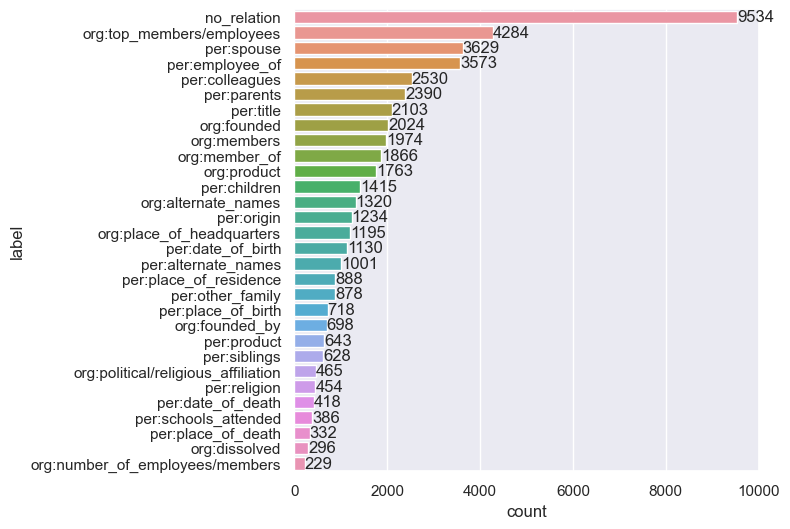

In [14]:
plt.subplots(figsize = (6,6))
sns.set(style='darkgrid')
ax = sns.countplot(y = df['label'], orient = 'h', order = df['label'].value_counts().index)
ax.bar_label(ax.containers[0])
#plt.tight_layout()
plt.show()

# 증강 데이터 확인

In [ ]:
random_id = random.choice(list(train_df.id))
print("1. original id: ", train_df[train_df.id == random_id].id)
print("2. original sentence: ", train_df[train_df.id == random_id].sentence)
print("3. original subject entity: ", train_df[train_df.id == random_id].subject_entity)
print("4. original object entity: ", train_df[train_df.id == random_id].object_entity)

print("5. Augmented sentences: ", df[df.id == random_id].sentence)
print("6. Augmented subject entities: ", df[df.id == random_id].subject_entity)
print("7. Augmented object entity: ", df[df.id == random_id].object_entity)

# 데이터 저장을 위한 id 재설정 및 shuffle

In [50]:
df = df.sample(frac=1).reset_index(drop=True)
df['id'] = range(len(df['id']))

In [51]:
df

,id,sentence,subject_entity,object_entity,label,source
0,0,1993년 《월간중앙》 7월호에 발표한 정치소설 에서 김영삼 대통령이 저격을 당하는...,"{'word': '김영삼', 'start_idx': 30, 'end_idx': 32...","{'word': '1993년', 'start_idx': 0, 'end_idx': 4...",no_relation,wikipedia
1,1,14대 대선에서 낙선하고 정계를 떠난 김대중이 정계 복귀와 신당 창당을 공식 선언하...,"{'word': '민주당', 'start_idx': 56, 'end_idx': 58...","{'word': '95명', 'start_idx': 63, 'end_idx': 65...",org:number_of_employees/members,wikipedia
2,2,"허 본부장은 1993년 소방간부후보생 7기로 공직에 입문해 부산 남부∙강서소방서장,...","{'word': '국민안전처', 'start_idx': 54, 'end_idx': ...","{'word': '국무총리', 'start_idx': 47, 'end_idx': 5...",no_relation,wikitree
3,3,채상욱 하나금융투자 연구원은 “HDC현대산업개발의 매출액은 지난해 같은 기간에 비해...,"{'word': 'HDC현대산업개발', 'start_idx': 17, 'end_id...","{'word': '아이파크캐슬', 'start_idx': 116, 'end_idx'...",org:product,wikitree
4,4,1990년대 발라드의 황제로 불린 신승훈은 자신의 데뷔 20주년 앨범을 유재하의 기...,"{'word': '신승훈', 'start_idx': 19, 'end_idx': 21...","{'word': '발라드', 'start_idx': 7, 'end_idx': 9, ...",no_relation,wikipedia
...,...,...,...,...,...,...
40012,40012,"그는 또 전 과 동행한 부인 이순자씨와도 마주쳤는데 ""이순자씨가 저한테 (전두환씨보...","{'word': '전두환', 'start_idx': 41, 'end_idx': 43...","{'word': '이순자', 'start_idx': 30, 'end_idx': 32...",per:spouse,wikitree
40013,40013,"대전지방법원, 대전지방검찰청 직속 관할 지역으로 그대로 유지되며, 대전지방법원 산하...","{'word': '세종지방경찰청', 'start_idx': 85, 'end_idx'...","{'word': '세종특별자치시', 'start_idx': 54, 'end_idx'...",org:member_of,wikipedia
40014,40014,오스틴 소재 텍사스 대학교 물리학자 J. 크레이그 휠러는 베텔게우스는 죽으면서 10...,"{'word': '텍사스', 'start_idx': 7, 'end_idx': 9, ...","{'word': '오스틴', 'start_idx': 0, 'end_idx': 2, ...",org:members,wikipedia
40015,40015,1479년에는 크리스티안 1세 국왕에 의해 코펜하겐 대학교가 설립되었는데 이 역시 ...,"{'word': '코펜하겐 대학', 'start_idx': 24, 'end_idx'...","{'word': '1479', 'start_idx': 0, 'end_idx': 3,...",org:founded,wikipedia


# 데이터 저장

In [52]:
df.to_csv('./augmented_train_data.csv', index = False)